In [1]:
!pip install tsfresh

  Obtaining dependency information for tsfresh from https://files.pythonhosted.org/packages/54/89/59db79edd22f6b339a7142dfc84b0be747952223578ef84e311001d27fd5/tsfresh-0.20.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for stumpy>=1.7.2 from https://files.pythonhosted.org/packages/c4/9d/9752261f8fe19ab4239caf1ba3864b04a0d7ab0033155cb11f86f124a642/stumpy-1.12.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/95.8 kB ? eta -:--:--
   ------------------------- -------------- 61.4/95.8 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 95.8/95.8 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/169.1 kB ? eta -:--:--
   -------------- ------------------------- 61.4/169.1 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 169.1/169.1 kB 2.6 MB/s eta 0:00:00


# Veri Yogun Uygulamalar Modul Projesi: Zaman serisi siniflandirma problemi

Dr. Ismail Guzel

Milli Teknoloji Hamlesi altinda Yapay Zeka Uzmanlık Programı kapsamında 18 saatlik Veri Yogun Uygulamar egitimi sonunda bu projenin tamamlanmasi beklenilmektedir.

Bu proje icerisinde amac farkli sektorlerden elde dilmis zaman serileri uzerinden elde edilen faktorler uzerine kurulmus bir classification modeli kurarak benzerlik calismasi yapmaktir.

Mesela ilgilenilen bir hisse senedi X olsun, bunun bulundugu sektor bazli diger hisse senetlerin davranislarindan farkli davrandigini dusunelim. Yani sektor icinde bir artis gozlemlenirken bu hisse senetinde bir hareketlilik olmasin. Dolayisiyla, hangi sektore daha cok benziyor sorusuna cevap verebilirsek, o sektor'un hareketlerine gore bir hipotez kurabiliriz.

Bu proje, asagidaki surecleri kapsayacak:

- Sektorleriin listesine bir web-scraping ile erisilmesi ve verilerin elde edilmesi (`yfinance`, `investpy`, [`quandl`]((https://docs.data.nasdaq.com/v1.0/docs/python-installation)))
- 2005-01-01 yilindan itibaren aylik getirelerden olusan serilerin elde edilmesi
- 3 buyuk sektor uzerinden getirilerin faktorleri(momentum gibi) hesaplanmasi
- Bu momentum serileri uzerinden bir tsfresh ile feature engineering yapilmasi (imputing, encoding, transformation, ve daha fazlasi)
- Yeni elde edilmis feature ve sektor siniflari uzerinden bir model kurulmasi (en iyi model secmesi)
- Diger sektorlerden ornekler alip ayni feature engine yontemleri yaptik sonra hangi sektore benzedigine karar vermek.
- **Bonus** Mesela Real-Estate sektorunde bulunan butun sembollerin tahmini edildikten sonra cogunluk hangi sektore(T,F,H) benzedigi bilgisine erismek.

In [1]:
!pip install yfinance

In [2]:
import yfinance
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

In [3]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

In [4]:
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1384,"9,687.20B",2.41%,14.70,17.75%,0.53%,11.62%
1,Healthcare,1216,"8,167.98B",0.43%,50.87,4.08%,1.31%,7.53%
2,Technology,788,17.72T,0.43%,44.88,13.16%,0.27%,14.87%
3,Industrials,651,"5,478.51B",1.11%,26.71,7.32%,0.55%,17.68%
4,Consumer Discretionary,577,"7,264.65B",0.65%,27.33,5.95%,0.31%,2.23%
5,Real Estate,264,"1,506.17B",4.13%,50.70,8.89%,-0.12%,6.92%
6,Materials,263,"2,069.65B",1.56%,19.61,8.68%,0.46%,2.26%
7,Communication Services,260,"5,361.34B",1.09%,28.01,10.40%,0.30%,2.10%
8,Energy,253,"3,646.12B",2.85%,8.01,12.42%,0.43%,18.22%
9,Consumer Staples,241,"4,035.49B",1.45%,29.74,4.72%,0.45%,12.15%


## Sektor listerine erismek

Yukarida yazilan fonksyionlar ile hangi sembollerin hangi sektorlerde oldugu bilgisine erisim saglanabilir ve asagidaki betikler yardimi ile `.csv` dosyalarinda saklayabiliriz. Sonrasinda, sektor bazli sembollere ait verileri indirilebilir ve siniflandirilabilir.

In [6]:
# dosya oluşturalım

import os
os.makedirs('/content/stock_sectors', exist_ok=True)

In [7]:
fetch_data(sectors='energy').to_csv('/content/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('/content/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('/content/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('/content/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('/content/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('/content/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('/content/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('/content/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('/content/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('/content/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('/content/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('/content/stock_sectors/communication-services.csv')

In [8]:
finance = pd.read_csv('/content/stock_sectors/financials.csv')
finance.Symbol
finance.columns

Index(['Unnamed: 0', 'Symbol', 'Company Name', 'Market Cap', '% Change',
       'Volume', 'Revenue'],
      dtype='object')

## Veriye erismek
Diyelim ki, finans sektorunden `HSBC` sembolu icin verileri indirmek istiyoruz. Bu adim icin `yfinance` kullanilabilir. Oncelikle `.Ticker` ile bir object olusturup onun uzerinden dogru hissemi olduguna dair bilgileri teyit edebiliriz. Sonrasinda `.get_history_metadata()` ile sembolun metedatasina erisim saglayabiliriz. Sonrasinda, `.history(period='3y')` ile 3 yillik veriyi calisma ortamimiza indirebiliriz.

In [9]:
import yfinance
ticker_name = yfinance.Ticker("HSBC")
ticker_name.info

{'address1': '8 Canada Square',
 'city': 'London',
 'zip': 'E14 5HQ',
 'country': 'United Kingdom',
 'phone': '44 20 7991 8888',
 'fax': '44 20 7992 4880',
 'website': 'https://www.hsbc.com',
 'industry': 'Banks—Diversified',
 'sector': 'Financial Services',
 'longBusinessSummary': 'HSBC Holdings plc provides banking and financial services worldwide. The company operates through Wealth and Personal Banking, Commercial Banking, and Global Banking and Markets segments. The Wealth and Personal Banking segment offers retail banking and wealth products, including current and savings accounts, mortgages and personal loans, credit and debit cards, and local and international payment services; and wealth management services comprising insurance and investment products, global asset management services, investment management, and private wealth solutions. This segment serves personal banking and high net worth individuals. The Commercial Banking segment provides credit and lending, treasury man

In [10]:
ticker_name.get_history_metadata()

{'currency': 'USD',
 'symbol': 'HSBC',
 'exchangeName': 'NYQ',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 932131800,
 'regularMarketTime': 1710532802,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 38.21,
 'chartPreviousClose': 37.44,
 'previousClose': 37.53,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1710489600,
   'end': 1710509400,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1710509400,
   'end': 1710532800,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1710532800,
   'end': 1710547200,
   'gmtoffset': -14400}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2024-03-11 00:00:00-04:00 2024-03-11 04:00:00-04:00 2024-03-11 09:30:00-04:00   
 2024-03-12 00:00:00-04:00 2024-03-12 04:00:00-0

In [11]:
data=ticker_name.history(period='3y')
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-11 00:00:00-04:00,37.029999,37.200001,36.930000,37.130001,2471600,0.0,0.0
2024-03-12 00:00:00-04:00,37.980000,38.090000,37.840000,38.009998,2409500,0.0,0.0
2024-03-13 00:00:00-04:00,38.119999,38.189999,37.790001,37.990002,2041000,0.0,0.0
2024-03-14 00:00:00-04:00,37.720001,37.810001,37.380001,37.529999,1389600,0.0,0.0
2024-03-15 00:00:00-04:00,38.090000,38.290001,38.040001,38.209999,2243000,0.0,0.0


Simdi ise, belirlenen sembollerin verilerini belli bir tarih sonrasinda cekebiliriz. Sonrasinda aylik getirileri hesaplayabiliriz. Proje kapsaminda bu yontem kullanilacak.

In [12]:
ticker_list=['AAPL', 'NVDA', 'INTC', 'ORCL', 'SONY']
data = yfinance.download(ticker_list, start='2005-01-01')
data_close=data['Adj Close'].resample('M').last().pct_change()+1

[*********************100%%**********************]  5 of 5 completed


In [13]:
data_close.AAPL

Date
2005-01-31         NaN
2005-02-28    1.166711
2005-03-31    0.928889
2005-04-30    0.865371
2005-05-31    1.102607
                ...   
2023-11-30    1.113780
2023-12-31    1.013583
2024-01-31    0.957773
2024-02-29    0.981457
2024-03-31    0.955021
Freq: M, Name: AAPL, Length: 231, dtype: float64

In [14]:
# 3 aylik momentum faktorleri
def get_rolling_ret(data, n):
    return data.rolling(n).apply(np.prod)
calisilacak_veri = get_rolling_ret(data_close, 3).dropna()
calisilacak_veri

Ticker,AAPL,INTC,NVDA,ORCL,SONY
Date,,,,,
2005-04-30,0.937842,1.051386,0.956806,0.839506,0.991626
2005-05-31,0.886313,1.127587,0.934805,0.988417,0.986240
2005-06-30,0.883370,1.123877,1.124579,1.057693,0.860570
2005-07-31,1.182751,1.157798,1.233926,1.173876,0.885590
2005-08-31,1.179326,0.956783,1.132104,1.014844,0.902066
...,...,...,...,...,...
2023-11-30,1.012404,1.276238,0.947703,0.968812,1.033177
2023-12-31,1.126007,1.418150,1.138563,0.999016,1.149011
2024-01-31,1.081238,1.184155,1.508887,1.084457,1.177002


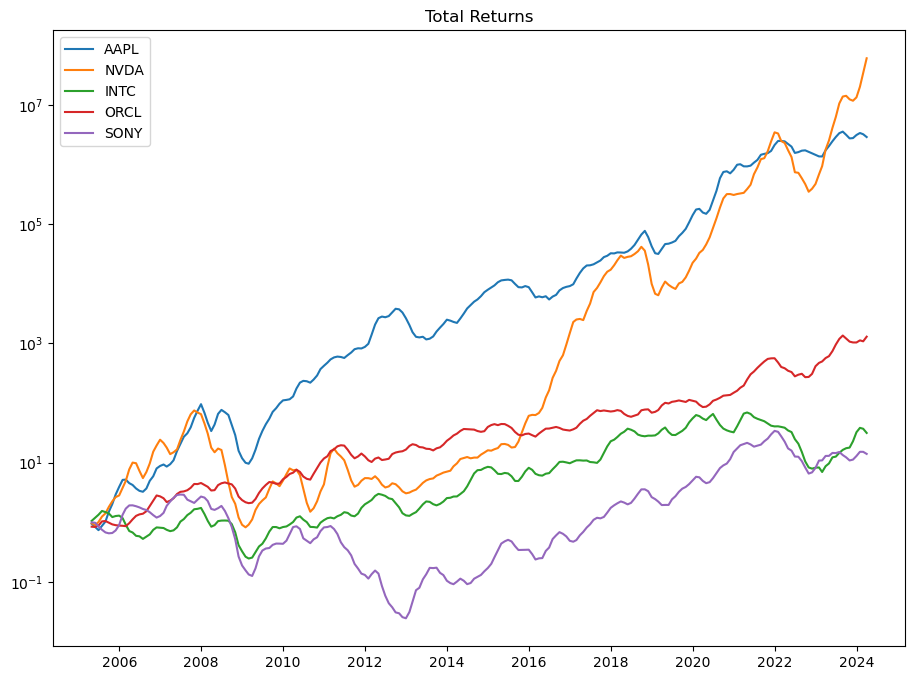

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=[11,8])

for ticker in ticker_list:
    plt.plot(calisilacak_veri[ticker].cumprod(), label = ticker)

plt.yscale('log')
plt.title('Total Returns')
plt.legend()
plt.show()

In [16]:
# yazılan tüm bilgileri ekrana yazdırmak icin

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [17]:
"""
def Weekly_Return(ticker_list, start_date='2005-01-01'):
    data = yfinance.download(ticker_list, start=start_date)
    weekly_data = data['Adj Close'].resample('W').last()
    weekly_return = weekly_data.pct_change() + 1
    return weekly_return
"""

In [18]:
# 3 ayrı sektor icin close degerleri
"""
financials_df = pd.read_csv("/content/stock_sectors/financials.csv")
ticker_list_financials = financials_df['Symbol'].to_list()

healthcare_df = pd.read_csv("/content/stock_sectors/healthcare.csv")
ticker_list_healthcare= healthcare_df['Symbol'].to_list()

technology_df = pd.read_csv("/content/stock_sectors/technology.csv")
ticker_list_technology= technology_df['Symbol'].to_list()

ticker_list_financials = [str(ticker) for ticker in ticker_list_financials]
ticker_list_healthcare = [str(ticker) for ticker in ticker_list_healthcare]
ticker_list_technology = [str(ticker) for ticker in ticker_list_technology]

data_closed_financials = Weekly_Return(ticker_list_financials)
data_closed_healthcare = Weekly_Return(ticker_list_healthcare)
data_closed_technology = Weekly_Return(ticker_list_technology)
"""


[*********************100%%**********************]  998 of 998 completed

8 Failed downloads:
['DYCQ', 'DISA', 'CRD.A', 'BNRE.A', 'AGM.A', 'LEGT', 'CRD.B', 'BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1217 of 1217 completed

1 Failed download:
['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-17)')
[*********************100%%**********************]  787 of 787 completed


In [19]:
# data_closed_financials

Ticker,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,ACAB,...,WU,WULF,XFIN,XP,XYF,YOTA,YRD,ZEO,ZION,ZLS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-16,NaN,NaN,NaN,0.987539,1.035370,0.969465,NaN,NaN,NaN,NaN,...,NaN,0.957849,NaN,NaN,NaN,NaN,NaN,NaN,0.977997,NaN
2005-01-23,NaN,NaN,NaN,0.977918,0.983039,1.018898,NaN,NaN,NaN,NaN,...,NaN,1.051593,NaN,NaN,NaN,NaN,NaN,NaN,1.034299,NaN
2005-01-30,NaN,NaN,NaN,0.974193,1.070474,1.027305,NaN,NaN,NaN,NaN,...,NaN,1.028860,NaN,NaN,NaN,NaN,NaN,NaN,1.007758,NaN
2005-02-06,NaN,NaN,NaN,1.006623,1.017022,1.002006,NaN,NaN,NaN,NaN,...,NaN,0.981767,NaN,NaN,NaN,NaN,NaN,NaN,1.056603,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18,1.007339,1.001428,0.975983,0.949020,1.004887,0.987300,1.064014,0.936893,0.996985,1.000000,...,1.025662,1.131818,0.997235,0.996794,1.035623,1.000000,1.143508,1.005370,1.024395,0.997214
2024-02-25,1.000911,1.002852,0.937360,1.115702,1.041092,0.967524,0.957724,0.949223,1.004536,1.011353,...,1.013292,0.815261,1.002773,0.966224,1.017199,0.985335,1.019920,1.006917,0.960384,1.000931
2024-03-03,0.999090,0.998104,1.000000,0.988889,0.959647,0.998256,1.027165,1.058952,1.002408,1.000000,...,1.040895,1.009852,1.000922,0.995006,1.026570,1.023256,1.078125,0.540000,0.993339,1.001861


In [20]:
"""
data_closed_financials
data_closed_healthcare
data_closed_technology
"""

Ticker,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,ACAB,...,WU,WULF,XFIN,XP,XYF,YOTA,YRD,ZEO,ZION,ZLS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-16,NaN,NaN,NaN,0.987539,1.035370,0.969465,NaN,NaN,NaN,NaN,...,NaN,0.957849,NaN,NaN,NaN,NaN,NaN,NaN,0.977997,NaN
2005-01-23,NaN,NaN,NaN,0.977918,0.983039,1.018898,NaN,NaN,NaN,NaN,...,NaN,1.051593,NaN,NaN,NaN,NaN,NaN,NaN,1.034299,NaN
2005-01-30,NaN,NaN,NaN,0.974193,1.070474,1.027305,NaN,NaN,NaN,NaN,...,NaN,1.028860,NaN,NaN,NaN,NaN,NaN,NaN,1.007758,NaN
2005-02-06,NaN,NaN,NaN,1.006623,1.017022,1.002006,NaN,NaN,NaN,NaN,...,NaN,0.981767,NaN,NaN,NaN,NaN,NaN,NaN,1.056603,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18,1.007339,1.001428,0.975983,0.949020,1.004887,0.987300,1.064014,0.936893,0.996985,1.000000,...,1.025662,1.131818,0.997235,0.996794,1.035623,1.000000,1.143508,1.005370,1.024395,0.997214
2024-02-25,1.000911,1.002852,0.937360,1.115702,1.041092,0.967524,0.957724,0.949223,1.004536,1.011353,...,1.013292,0.815261,1.002773,0.966224,1.017199,0.985335,1.019920,1.006917,0.960384,1.000931
2024-03-03,0.999090,0.998104,1.000000,0.988889,0.959647,0.998256,1.027165,1.058952,1.002408,1.000000,...,1.040895,1.009852,1.000922,0.995006,1.026570,1.023256,1.078125,0.540000,0.993339,1.001861


Ticker,A,AADI,ABBV,ABCL,ABEO,ABIO,ABOS,ABSI,ABT,ABUS,...,ZLAB,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-16,0.970938,NaN,NaN,NaN,0.981538,0.960326,NaN,NaN,0.979091,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.074071
2005-01-23,0.988662,NaN,NaN,NaN,0.981191,0.958686,NaN,NaN,0.994162,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965517
2005-01-30,0.991284,NaN,NaN,NaN,0.888179,0.875138,NaN,NaN,0.984559,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2005-02-06,1.038871,NaN,NaN,NaN,1.093525,1.035354,NaN,NaN,1.005522,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18,1.011249,1.016043,1.019589,1.045010,1.130645,1.006024,1.012346,1.239535,1.019676,1.050725,...,1.104925,1.127826,0.944882,0.867133,0.954744,0.975000,1.115447,1.010274,1.078027,1.023349
2024-02-25,0.979161,1.000000,1.003380,0.911985,0.995720,0.976048,1.085366,0.879925,1.047803,1.006897,...,0.966085,1.051658,1.041667,1.008065,1.046818,0.935897,0.966472,1.357627,0.993344,1.015736
2024-03-03,1.053245,1.010526,1.004604,1.036961,1.118911,1.024540,1.303371,1.164179,0.992968,0.955479,...,1.058175,1.120235,1.240000,0.984000,0.967598,1.005479,1.067873,1.298377,1.047739,0.952750


Ticker,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,ADSK,...,YOU,ZBRA,ZENV,ZEPP,ZETA,ZFOX,ZI,ZM,ZS,ZUO
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-16,NaN,1.013718,1.006637,1.073638,NaN,0.987974,0.990643,1.130089,1.002532,0.923615,...,NaN,0.964218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-23,NaN,1.004131,0.980769,0.964335,NaN,0.957018,0.980079,0.983816,0.967172,0.988636,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-30,NaN,1.049510,1.172549,1.032717,NaN,1.017488,0.972139,1.005572,1.007833,0.911877,...,NaN,0.978711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-06,NaN,1.065694,1.022456,1.181818,NaN,1.005078,1.153389,1.002639,1.080023,1.098039,...,NaN,1.032728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18,1.065402,0.965369,1.008508,0.931854,1.068194,0.994108,0.871574,0.926606,0.965234,0.968577,...,0.983623,1.088388,0.994792,1.056911,1.034034,1.009009,1.136452,0.945510,0.991449,0.955479
2024-02-25,0.663074,1.001152,1.002596,0.938945,1.046476,1.021219,1.012403,0.937294,1.009934,0.995741,...,0.942248,0.998294,1.000000,0.907692,0.997096,1.000000,0.985706,1.020605,0.930682,0.978495
2024-03-03,1.089046,0.984330,1.039806,1.060374,1.654954,1.009726,1.031602,1.014965,1.031824,1.029316,...,1.013805,1.053275,1.078534,1.042373,1.002913,0.991071,0.978538,1.118454,0.931981,0.978022


In [182]:
# Veri setinin indeksini sıradan bir sütuna dönüştürme
"""
data_closed_financials.reset_index(inplace=True)
data_closed_financials
"""

'\ndata_closed_financials.reset_index(inplace=True)\ndata_closed_financials'

In [22]:
# data_closed_healthcare.reset_index(inplace=True)
# data_closed_healthcare

Ticker,Date,A,AADI,ABBV,ABCL,ABEO,ABIO,ABOS,ABSI,ABT,...,ZLAB,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYME,ZYXI
0,2005-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-16,0.970938,NaN,NaN,NaN,0.981538,0.960326,NaN,NaN,0.979091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.074071
2,2005-01-23,0.988662,NaN,NaN,NaN,0.981191,0.958686,NaN,NaN,0.994162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965517
3,2005-01-30,0.991284,NaN,NaN,NaN,0.888179,0.875138,NaN,NaN,0.984559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4,2005-02-06,1.038871,NaN,NaN,NaN,1.093525,1.035354,NaN,NaN,1.005522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,2024-02-18,1.011249,1.016043,1.019589,1.045010,1.130645,1.006024,1.012346,1.239535,1.019676,...,1.104925,1.127826,0.944882,0.867133,0.954744,0.975000,1.115447,1.010274,1.078027,1.023349
998,2024-02-25,0.979161,1.000000,1.003380,0.911985,0.995720,0.976048,1.085366,0.879925,1.047803,...,0.966085,1.051658,1.041667,1.008065,1.046818,0.935897,0.966472,1.357627,0.993344,1.015736
999,2024-03-03,1.053245,1.010526,1.004604,1.036961,1.118911,1.024540,1.303371,1.164179,0.992968,...,1.058175,1.120235,1.240000,0.984000,0.967598,1.005479,1.067873,1.298377,1.047739,0.952750
1000,2024-03-10,1.063354,1.114583,0.999665,0.944554,1.020487,0.982036,0.941810,0.919414,1.019727,...,0.896209,1.007199,0.909677,1.048780,0.954617,0.882834,0.861582,0.912500,0.914468,1.045528


In [23]:
# data_closed_technology.reset_index(inplace=True)
# data_closed_technology

Ticker,Date,AAOI,AAPL,ACIW,ACLS,ACMR,ACN,ADBE,ADEA,ADI,...,YOU,ZBRA,ZENV,ZEPP,ZETA,ZFOX,ZI,ZM,ZS,ZUO
0,2005-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-16,NaN,1.013718,1.006637,1.073638,NaN,0.987974,0.990643,1.130089,1.002532,...,NaN,0.964218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-23,NaN,1.004131,0.980769,0.964335,NaN,0.957018,0.980079,0.983816,0.967172,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-30,NaN,1.049510,1.172549,1.032717,NaN,1.017488,0.972139,1.005572,1.007833,...,NaN,0.978711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-02-06,NaN,1.065694,1.022456,1.181818,NaN,1.005078,1.153389,1.002639,1.080023,...,NaN,1.032728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,2024-02-18,1.065402,0.965369,1.008508,0.931854,1.068194,0.994108,0.871574,0.926606,0.965234,...,0.983623,1.088388,0.994792,1.056911,1.034034,1.009009,1.136452,0.945510,0.991449,0.955479
998,2024-02-25,0.663074,1.001152,1.002596,0.938945,1.046476,1.021219,1.012403,0.937294,1.009934,...,0.942248,0.998294,1.000000,0.907692,0.997096,1.000000,0.985706,1.020605,0.930682,0.978495
999,2024-03-03,1.089046,0.984330,1.039806,1.060374,1.654954,1.009726,1.031602,1.014965,1.031824,...,1.013805,1.053275,1.078534,1.042373,1.002913,0.991071,0.978538,1.118454,0.931981,0.978022
1000,2024-03-10,0.957820,0.950295,0.998755,0.962501,0.889413,0.992598,0.966301,0.989592,0.998878,...,1.111111,0.975659,0.995146,0.943089,0.987415,1.000000,0.978660,0.947116,0.906308,1.147316


In [24]:
"""
def Transform_Dataset(data):
  # melt() fonksiyonunu kullanarak veri setini dönüştür
  transform_data = data.melt(id_vars=['Date'], var_name='Ticker', value_name='Close')
  # Sonuçları sırala
  transform_data = transform_data.sort_values(by=['Ticker', 'Date'])

  return transform_data
"""

In [25]:
"""
financials = Transform_Dataset(data_closed_financials)
healthcare = Transform_Dataset(data_closed_healthcare)
technology = Transform_Dataset(data_closed_technology)
"""

In [26]:
"""
financials
healthcare
technology
"""

,Date,Ticker,Close
0,2005-01-09,AACI,NaN
1,2005-01-16,AACI,NaN
2,2005-01-23,AACI,NaN
3,2005-01-30,AACI,NaN
4,2005-02-06,AACI,NaN
...,...,...,...
999991,2024-02-18,ZLS,0.997214
999992,2024-02-25,ZLS,1.000931
999993,2024-03-03,ZLS,1.001861
999994,2024-03-10,ZLS,1.000000


,Date,Ticker,Close
0,2005-01-09,A,NaN
1,2005-01-16,A,0.970938
2,2005-01-23,A,0.988662
3,2005-01-30,A,0.991284
4,2005-02-06,A,1.038871
...,...,...,...
1219429,2024-02-18,ZYXI,1.023349
1219430,2024-02-25,ZYXI,1.015736
1219431,2024-03-03,ZYXI,0.952750
1219432,2024-03-10,ZYXI,1.045528


,Date,Ticker,Close
0,2005-01-09,AAOI,NaN
1,2005-01-16,AAOI,NaN
2,2005-01-23,AAOI,NaN
3,2005-01-30,AAOI,NaN
4,2005-02-06,AAOI,NaN
...,...,...,...
788569,2024-02-18,ZUO,0.955479
788570,2024-02-25,ZUO,0.978495
788571,2024-03-03,ZUO,0.978022
788572,2024-03-10,ZUO,1.147316


In [27]:
# Momentum hesaplama fonksiyonu
"""
def calculate_momentum(data, window=3):
  # Belirtilen pencere boyutunda momentumu hesaplayalım
  data['Momentum'] = data['Close'].pct_change().rolling(window).sum()
  data.drop(['Close'], axis = 1, inplace=True)
  return data
"""

In [28]:
"""
financials = calculate_momentum(financials)
healthcare = calculate_momentum(healthcare)
technology = calculate_momentum(technology)
"""

In [29]:
# veri setlerindeki sum değerlerin kontrolü
"""
print("Financials:\n", financials.isnull().sum())
print("\nHealthcare:\n", healthcare.isnull().sum())
print("\nTechnology:\n", technology.isnull().sum())
"""

Financials:
 Date          0
Ticker        0
Momentum    883
dtype: int64

Healthcare:
 Date        0
Ticker      0
Momentum    4
dtype: int64

Technology:
 Date          0
Ticker        0
Momentum    459
dtype: int64


In [ ]:
# tsfresh kütüphanesi ile extract feature adımı.
# MinimalFCParameters'da kullandım ancak 10 feature oluşturuyordu ve bu benim için yeterli değildi.
"""
import tsfresh
def Extract_Features(data, columd_id, column_sort, nan_column):
  cleaned_data = data.dropna(subset=[nan_column])
  features = tsfresh.extract_features(cleaned_data, column_id='Ticker', column_sort='Date',
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
  return features
"""

In [31]:
"""
financials_features = Extract_Features(financials, 'Ticker', 'Date', 'Momentum')
financials_features.columns
financials_features
financials_features.shape
"""

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:47<00:00,  2.69s/it]


Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean_second_derivative_central',
       'Momentum__median',
       ...
       'Momentum__fourier_entropy__bins_5',
       'Momentum__fourier_entropy__bins_10',
       'Momentum__fourier_entropy__bins_100',
       'Momentum__permutation_entropy__dimension_3__tau_1',
       'Momentum__permutation_entropy__dimension_4__tau_1',
       'Momentum__permutation_entropy__dimension_5__tau_1',
       'Momentum__permutation_entropy__dimension_6__tau_1',
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
AACI,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,0.000015,...,1.207192,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,NaN,0.036588
AACT,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,0.000000,...,0.090729,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,NaN,0.005461
AAMC,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,0.000000,...,0.090729,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,NaN,1.200893
AAME,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,0.003561,...,0.991529,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,NaN,1.545175
AB,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,0.001971,...,1.434492,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,NaN,0.587840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOTA,0.0,0.0,0.0,1.0,0.010199,0.008469,0.000896,0.000027,-1.133860e-05,0.000000,...,0.090729,0.090729,0.090729,0.397793,0.549283,0.666726,0.704159,0.716431,NaN,0.025752
YRD,0.0,0.0,0.0,1.0,14.714262,11.781272,0.070568,0.000136,1.617781e-04,0.000000,...,1.039301,1.680354,3.677994,1.226122,1.917067,2.609999,3.079511,3.238581,NaN,0.572163
ZEO,0.0,0.0,0.0,1.0,0.653083,0.865101,0.002992,0.000385,-1.750620e-04,0.000000,...,0.090729,0.090729,0.090729,0.481994,0.689122,0.845497,0.917995,0.932708,NaN,0.285895
ZION,0.0,0.0,0.0,0.0,14.565792,12.553468,0.090947,-0.000909,4.753460e-04,0.004466,...,1.063894,1.728228,3.706751,1.789554,3.136163,4.631223,5.997802,6.708307,NaN,0.800955


(998, 783)

In [ ]:
# financials_features.columns

In [33]:
"""
healthcare_features = Extract_Features(healthcare, 'Ticker', 'Date', 'Momentum')
healthcare_features.columns
healthcare_features
healthcare_features.shape
"""

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [02:11<00:00,  3.28s/it]


Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean_second_derivative_central',
       'Momentum__median',
       ...
       'Momentum__fourier_entropy__bins_5',
       'Momentum__fourier_entropy__bins_10',
       'Momentum__fourier_entropy__bins_100',
       'Momentum__permutation_entropy__dimension_3__tau_1',
       'Momentum__permutation_entropy__dimension_4__tau_1',
       'Momentum__permutation_entropy__dimension_5__tau_1',
       'Momentum__permutation_entropy__dimension_6__tau_1',
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,0.0,0.0,5.186246,3.466913,0.061753,-0.000046,-0.000015,0.002163,...,1.203160,1.815738,3.750810,1.788116,3.123647,4.598024,5.926141,6.656596,NaN,0.294794
AADI,0.0,0.0,0.0,1.0,18.409666,21.951392,0.058081,0.000076,-0.000032,0.000000,...,1.062226,1.688896,3.640766,1.004254,1.527350,2.021098,2.326213,2.427592,NaN,1.316356
ABBV,0.0,0.0,0.0,1.0,2.458033,1.662653,0.032487,-0.000022,0.000057,0.000000,...,1.331614,1.973899,3.888503,1.470795,2.410904,3.349560,4.054154,4.358745,NaN,0.208324
ABCL,0.0,0.0,0.0,1.0,4.152778,3.272890,0.023131,0.000103,0.000084,0.000000,...,0.920428,1.522842,3.434141,0.589907,0.886187,1.158575,1.292243,1.323291,NaN,0.335010
ABEO,0.0,0.0,0.0,0.0,64.462847,74.222120,0.213862,0.000140,0.000049,0.025391,...,1.458319,2.076149,3.866038,1.789445,3.140311,4.624038,5.981507,6.681520,NaN,1.649341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,0.0,0.0,0.0,1.0,3.450205,2.673667,0.011201,0.000089,0.000071,0.000000,...,0.090729,0.090729,0.090729,0.231691,0.332317,0.392425,0.401634,0.403376,NaN,0.464415
ZVRA,0.0,0.0,0.0,1.0,23.357577,20.420010,0.088531,0.000060,0.000077,0.000000,...,0.510484,1.112779,3.220994,1.311377,2.038502,2.783709,3.305902,3.495986,NaN,0.968016
ZVSA,0.0,0.0,0.0,1.0,17.411291,35.366603,0.030432,-0.000387,-0.000318,0.000000,...,0.090729,0.090729,0.090729,0.466044,0.661640,0.802378,0.857473,0.865175,NaN,1.902636
ZYME,0.0,0.0,0.0,1.0,9.292400,7.213456,0.050191,0.000356,-0.000093,0.000000,...,0.935052,1.507301,3.537964,1.081301,1.660902,2.248320,2.630741,2.735970,NaN,0.496815


(1217, 783)

In [35]:
"""
technology_features = Extract_Features(technology, 'Ticker', 'Date', 'Momentum')
technology_features.columns
technology_features
technology_features.shape
"""

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:31<00:00,  2.29s/it]


Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean_second_derivative_central',
       'Momentum__median',
       ...
       'Momentum__fourier_entropy__bins_5',
       'Momentum__fourier_entropy__bins_10',
       'Momentum__fourier_entropy__bins_100',
       'Momentum__permutation_entropy__dimension_3__tau_1',
       'Momentum__permutation_entropy__dimension_4__tau_1',
       'Momentum__permutation_entropy__dimension_5__tau_1',
       'Momentum__permutation_entropy__dimension_6__tau_1',
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
AAOI,0.0,0.0,0.0,0.0,16.612742,13.596917,0.151139,0.000573,0.000318,0.019508,...,0.924484,1.550784,3.493570,1.786941,3.137660,4.577971,5.704455,6.172068,NaN,0.550275
AAPL,0.0,0.0,0.0,0.0,6.087435,4.137667,0.066161,0.000235,-0.000136,0.002182,...,0.925113,1.543162,3.592596,1.791091,3.135018,4.612347,5.944089,6.665684,NaN,0.270994
ACIW,0.0,0.0,0.0,0.0,8.915415,6.625806,0.082347,-0.000039,-0.000016,0.006464,...,1.274302,1.949306,3.919857,1.789271,3.137851,4.634798,6.007290,6.693706,NaN,0.460376
ACLS,0.0,0.0,0.0,0.0,26.235833,21.741340,0.131660,0.000082,-0.000065,0.015394,...,1.057437,1.726478,3.713528,1.788973,3.126029,4.620516,5.978243,6.705707,NaN,0.933264
ACMR,0.0,0.0,0.0,1.0,12.414037,9.403748,0.053586,0.000223,-0.000031,0.000000,...,0.868703,1.487988,3.500004,1.032005,1.601757,2.122982,2.448476,2.555723,NaN,0.565718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFOX,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,0.000006,0.000000,...,0.893126,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,NaN,0.949272
ZI,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,0.000066,0.000000,...,0.885986,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,NaN,0.398101
ZM,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-0.000021,0.000000,...,1.011227,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,NaN,0.293024
ZS,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-0.000007,0.000000,...,0.677534,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,NaN,0.404840


(787, 783)

In [124]:
# Oluşturulan veri setlerin

"""
financials_features['Sector'] = "Financials"
healthcare_features['Sector'] = "Healthcare"
technology_features['Sector'] = "Technology"

data = pd.concat([financials_features, healthcare_features, technology_features], ignore_index=True)
data
"""

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7,Sector
0,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,0.000015,...,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,NaN,0.036588,Financials
1,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,0.000000,...,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,NaN,0.005461,Financials
2,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,0.000000,...,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,NaN,1.200893,Financials
3,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,0.003561,...,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,NaN,1.545175,Financials
4,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,0.001971,...,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,NaN,0.587840,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,5.747129e-06,0.000000,...,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,NaN,0.949272,Technology
2998,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,6.563868e-05,0.000000,...,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,NaN,0.398101,Technology
2999,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-2.116363e-05,0.000000,...,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,NaN,0.293024,Technology
3000,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-7.201400e-06,0.000000,...,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,NaN,0.404840,Technology


In [125]:
"""
sector_column = data.pop('Sector')
data.insert(0, 'Sector', sector_column)
data.head()
"""

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
0,Financials,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,...,1.207192,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,NaN,0.036588
1,Financials,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,...,0.090729,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,NaN,0.005461
2,Financials,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,...,0.090729,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,NaN,1.200893
3,Financials,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,...,0.991529,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,NaN,1.545175
4,Financials,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,...,1.434492,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,NaN,0.587840


In [126]:
# data

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
0,Financials,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,...,1.207192,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,NaN,0.036588
1,Financials,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,...,0.090729,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,NaN,0.005461
2,Financials,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,...,0.090729,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,NaN,1.200893
3,Financials,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,...,0.991529,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,NaN,1.545175
4,Financials,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,...,1.434492,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,NaN,0.587840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,Technology,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,5.747129e-06,...,0.893126,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,NaN,0.949272
2998,Technology,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,6.563868e-05,...,0.885986,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,NaN,0.398101
2999,Technology,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-2.116363e-05,...,1.011227,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,NaN,0.293024
3000,Technology,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-7.201400e-06,...,0.677534,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,NaN,0.404840


In [127]:
# data.isnull().sum()

Sector                                                            0
Momentum__variance_larger_than_standard_deviation                 0
Momentum__has_duplicate_max                                       0
Momentum__has_duplicate_min                                       0
Momentum__has_duplicate                                           0
                                                               ... 
Momentum__permutation_entropy__dimension_5__tau_1                 0
Momentum__permutation_entropy__dimension_6__tau_1                 0
Momentum__permutation_entropy__dimension_7__tau_1                 0
Momentum__query_similarity_count__query_None__threshold_0.0    3002
Momentum__mean_n_absolute_max__number_of_maxima_7                 0
Length: 784, dtype: int64

In [128]:
"""
cleaned_data = data.drop(['Momentum__query_similarity_count__query_None__threshold_0.0'],axis = 1)
cleaned_data.isnull().sum()
"""

Sector                                               0
Momentum__variance_larger_than_standard_deviation    0
Momentum__has_duplicate_max                          0
Momentum__has_duplicate_min                          0
Momentum__has_duplicate                              0
                                                    ..
Momentum__permutation_entropy__dimension_4__tau_1    0
Momentum__permutation_entropy__dimension_5__tau_1    0
Momentum__permutation_entropy__dimension_6__tau_1    0
Momentum__permutation_entropy__dimension_7__tau_1    0
Momentum__mean_n_absolute_max__number_of_maxima_7    0
Length: 783, dtype: int64

In [129]:
"""
duplicate_rows = data.duplicated()
print(duplicate_rows.sum())
"""

0


In [130]:
"""
# Boş değerleri satırdaki diğer değerlerle doldurun
filled_data = data.apply(lambda row: row.fillna(method='ffill').fillna(method='bfill'), axis=1)
df = filled_data
"""

In [131]:
# df

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
0,Financials,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,...,1.207192,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,4.690584,0.036588
1,Financials,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,...,0.090729,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,0.324496,0.005461
2,Financials,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,...,0.090729,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,0.819639,1.200893
3,Financials,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,...,0.991529,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,6.688821,1.545175
4,Financials,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,...,1.434492,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,6.650120,0.587840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,Technology,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,5.747129e-06,...,0.893126,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,1.304744,0.949272
2998,Technology,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,6.563868e-05,...,0.885986,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,1.530339,0.398101
2999,Technology,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-2.116363e-05,...,1.011227,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,1.970852,0.293024
3000,Technology,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-7.201400e-06,...,0.677534,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,2.428049,0.404840


In [132]:
# df.isnull().sum().to_list()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [133]:
"""
data = df.drop(['Sector'], axis = 1)
data
"""

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,0.000015,...,1.207192,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,4.690584,0.036588
1,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,0.000000,...,0.090729,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,0.324496,0.005461
2,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,0.000000,...,0.090729,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,0.819639,1.200893
3,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,0.003561,...,0.991529,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,6.688821,1.545175
4,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,0.001971,...,1.434492,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,6.650120,0.587840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,5.747129e-06,0.000000,...,0.893126,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,1.304744,0.949272
2998,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,6.563868e-05,0.000000,...,0.885986,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,1.530339,0.398101
2999,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-2.116363e-05,0.000000,...,1.011227,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,1.970852,0.293024
3000,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-7.201400e-06,0.000000,...,0.677534,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,2.428049,0.404840


In [134]:
"""
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# LabelEncoder nesnesini oluşturun
encoder = LabelEncoder()

# Sector sütununu bir sütun vektörüne dönüştürün ve etiketleyin
encoded_sector = encoder.fit_transform(df['Sector'].values.ravel())

# Veriye kodlanmış sektör sütununu ekleyin
encoded_sector_df = pd.DataFrame(encoded_sector, columns=['Sector'])
filled_data = pd.concat([encoded_sector_df, data], axis=1)

# Veri setinizi kontrol edin
filled_data
"""

      Sector  Momentum__variance_larger_than_standard_deviation  \
0          0                                                0.0   
1          0                                                0.0   
2          0                                                0.0   
3          0                                                0.0   
4          0                                                0.0   
...      ...                                                ...   
2997       2                                                0.0   
2998       2                                                0.0   
2999       2                                                0.0   
3000       2                                                0.0   
3001       2                                                0.0   

      Momentum__has_duplicate_max  Momentum__has_duplicate_min  \
0                             0.0                          0.0   
1                             0.0                          0.0 

In [135]:
"""
df = filled_data
df
"""

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
0,0,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,...,1.207192,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,4.690584,0.036588
1,0,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,...,0.090729,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,0.324496,0.005461
2,0,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,...,0.090729,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,0.819639,1.200893
3,0,0.0,0.0,0.0,1.0,27.202243,33.296453,0.113939,-0.000080,-1.966878e-04,...,0.991529,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,6.688821,1.545175
4,0,0.0,0.0,0.0,0.0,8.375681,7.170079,0.076626,-0.000024,-4.886630e-05,...,1.434492,2.048159,3.907812,1.788306,3.114151,4.571062,5.894414,6.650120,6.650120,0.587840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,2,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,5.747129e-06,...,0.893126,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,1.304744,0.949272
2998,2,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,6.563868e-05,...,0.885986,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,1.530339,0.398101
2999,2,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-2.116363e-05,...,1.011227,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,1.970852,0.293024
3000,2,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-7.201400e-06,...,0.677534,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,2.428049,0.404840


In [136]:
"""
# Veriyi dengelemek için veri setini karıştırıyoruz.

shuffled_df = df.sample(frac=1, random_state=42)
shuffled_df
"""

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
2786,2,0.0,0.0,0.0,1.0,3.701166,2.331550,0.018370,-0.000170,-0.000113,...,0.090729,0.090729,0.875401,0.522269,0.751505,0.926261,1.002998,1.027709,1.027709,0.347352
2148,1,0.0,0.0,0.0,1.0,8.551743,7.330378,0.036068,-0.000455,-0.000719,...,1.132314,1.621145,3.493409,0.712846,1.059561,1.365861,1.522190,1.561257,1.561257,0.593461
1410,1,0.0,0.0,0.0,1.0,19.112101,28.792285,0.059793,0.000231,0.000093,...,0.941520,1.559937,3.437164,0.924673,1.399001,1.806220,2.068790,2.170616,2.170616,1.441095
251,0,0.0,0.0,0.0,0.0,36.968941,38.294592,0.142964,0.000007,-0.000031,...,1.325577,1.944941,3.931140,1.789590,3.139035,4.612654,5.956836,6.666367,6.666367,1.407797
2506,2,0.0,0.0,0.0,0.0,23.510833,18.521854,0.134418,-0.000677,0.000234,...,1.319919,1.991410,3.935545,1.787848,3.133915,4.623749,5.996563,6.686562,6.686562,0.708492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,0.0,0.0,0.0,1.0,9.588095,8.128816,0.033628,0.000017,0.000005,...,1.402898,2.015981,3.900135,0.808759,1.158042,1.485030,1.661463,1.711761,1.711761,0.683358
1095,1,0.0,0.0,0.0,1.0,8.884760,7.728646,0.034543,0.000368,0.000204,...,1.115872,1.738136,3.654442,0.660198,1.001585,1.292891,1.450833,1.491813,1.491813,0.635245
1130,1,0.0,0.0,0.0,1.0,10.239820,18.980087,0.033538,-0.000532,-0.000064,...,0.924278,1.512820,3.369562,0.673840,0.985754,1.262839,1.387671,1.424432,1.424432,1.273332
1294,1,0.0,0.0,0.0,1.0,18.186910,29.756955,0.046929,0.000115,0.000001,...,0.079983,0.217718,1.109400,0.623204,0.870033,1.095920,1.192898,1.224387,1.224387,1.688051


## Verileri Görselleştirme

<Figure size 1200x800 with 0 Axes>

array([[<Axes: title={'center': 'Momentum__sum_values'}>,
        <Axes: title={'center': 'Momentum__median'}>]], dtype=object)

<Figure size 1200x800 with 0 Axes>

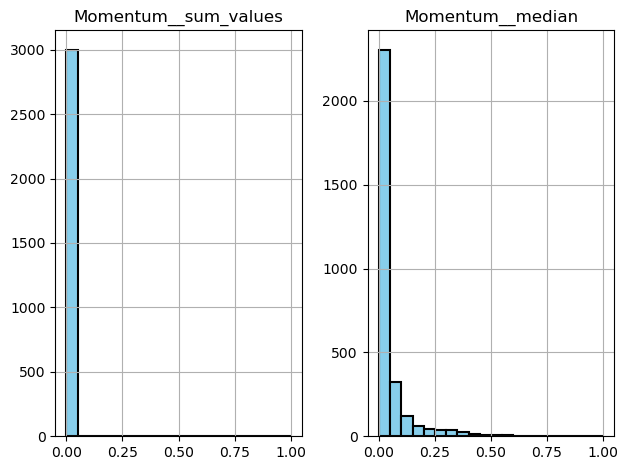

In [56]:
"""
import seaborn as sns

plt.figure(figsize=(12, 8))
shuffled_df.hist(column=['Momentum__sum_values', 'Momentum__median'], bins=20, color='skyblue', edgecolor='black', linewidth=1.5)
plt.tight_layout()
plt.show()
"""

In [151]:
"""
data = shuffled_df
shuffled_df
shuffled_df.shape
"""

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
1801,1,0.0,0.0,0.0,1.0,25.585615,23.493437,0.096034,-0.000301,0.000023,...,1.226979,1.874416,3.756529,1.339258,2.153308,2.969374,3.541894,3.760648,0.0,0.985055
1190,1,0.0,0.0,0.0,0.0,9.857203,7.378697,0.077614,-0.000364,-0.000168,...,1.253155,1.930648,3.877010,1.790987,3.132755,4.606354,5.934078,6.657149,0.0,0.501907
1817,1,0.0,0.0,0.0,1.0,16.814017,18.419448,0.026898,0.000133,-0.000103,...,0.090729,0.090729,0.090729,0.450529,0.643555,0.798145,0.842713,0.850929,0.0,1.247192
251,0,0.0,0.0,0.0,0.0,36.968963,38.294618,0.142964,0.000007,-0.000031,...,1.325577,1.944941,3.931140,1.789590,3.139035,4.612654,5.956836,6.666367,0.0,1.407798
2505,2,0.0,0.0,0.0,0.0,23.510833,18.521854,0.134418,-0.000677,0.000234,...,1.319919,1.991410,3.935545,1.787848,3.133915,4.623749,5.996563,6.686562,0.0,0.708492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,0.0,0.0,0.0,1.0,9.588095,8.128816,0.033628,0.000017,0.000005,...,1.402898,2.015981,3.900135,0.808759,1.158042,1.485030,1.661463,1.711761,0.0,0.683358
1095,1,0.0,0.0,0.0,1.0,8.884760,7.728646,0.034543,0.000368,0.000204,...,1.115872,1.738136,3.654442,0.660198,1.001585,1.292891,1.450833,1.491813,0.0,0.635245
1130,1,0.0,0.0,0.0,1.0,10.239820,18.980087,0.033538,-0.000532,-0.000064,...,0.924278,1.512820,3.369562,0.673840,0.985754,1.262839,1.387671,1.424432,0.0,1.273332
1294,1,0.0,0.0,0.0,1.0,18.186910,29.756955,0.046929,0.000115,0.000001,...,0.079983,0.217718,1.109400,0.623204,0.870033,1.095920,1.192898,1.224387,0.0,1.688051


(3001, 784)

In [143]:
"""
data = shuffled_df
data
"""

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
2786,2,0.0,0.0,0.0,1.0,3.701166,2.331550,0.018370,-0.000170,-0.000113,...,0.090729,0.090729,0.875401,0.522269,0.751505,0.926261,1.002998,1.027709,1.027709,0.347352
2148,1,0.0,0.0,0.0,1.0,8.551743,7.330378,0.036068,-0.000455,-0.000719,...,1.132314,1.621145,3.493409,0.712846,1.059561,1.365861,1.522190,1.561257,1.561257,0.593461
1410,1,0.0,0.0,0.0,1.0,19.112101,28.792285,0.059793,0.000231,0.000093,...,0.941520,1.559937,3.437164,0.924673,1.399001,1.806220,2.068790,2.170616,2.170616,1.441095
251,0,0.0,0.0,0.0,0.0,36.968941,38.294592,0.142964,0.000007,-0.000031,...,1.325577,1.944941,3.931140,1.789590,3.139035,4.612654,5.956836,6.666367,6.666367,1.407797
2506,2,0.0,0.0,0.0,0.0,23.510833,18.521854,0.134418,-0.000677,0.000234,...,1.319919,1.991410,3.935545,1.787848,3.133915,4.623749,5.996563,6.686562,6.686562,0.708492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,0.0,0.0,0.0,1.0,9.588095,8.128816,0.033628,0.000017,0.000005,...,1.402898,2.015981,3.900135,0.808759,1.158042,1.485030,1.661463,1.711761,1.711761,0.683358
1095,1,0.0,0.0,0.0,1.0,8.884760,7.728646,0.034543,0.000368,0.000204,...,1.115872,1.738136,3.654442,0.660198,1.001585,1.292891,1.450833,1.491813,1.491813,0.635245
1130,1,0.0,0.0,0.0,1.0,10.239820,18.980087,0.033538,-0.000532,-0.000064,...,0.924278,1.512820,3.369562,0.673840,0.985754,1.262839,1.387671,1.424432,1.424432,1.273332
1294,1,0.0,0.0,0.0,1.0,18.186910,29.756955,0.046929,0.000115,0.000001,...,0.079983,0.217718,1.109400,0.623204,0.870033,1.095920,1.192898,1.224387,1.224387,1.688051


In [403]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import yfinance as yf
import pandas as pd
import tsfresh

In [457]:
def Weekly_Return(ticker_list, start_date='2005-01-01'):
    if isinstance(ticker_list, str):  # Tek bir sembol varsa
        ticker_list = [ticker_list]
    elif isinstance(ticker_list, pd.DataFrame):  # DataFrame varsa
        ticker_list = ticker_list['Symbol'].tolist()
    data = yf.download(tickers=ticker_list, start=start_date)
    weekly_data = data['Adj Close'].resample('W').last()
    weekly_return = weekly_data.pct_change() + 1
    return weekly_return.reset_index()

In [405]:
# Veri setini dönüştüren fonksiyon
def Transform_Dataset(data):
    transform_data = data.melt(id_vars=['Date'], var_name='Ticker', value_name='Close')
    transform_data = transform_data.sort_values(by=['Ticker', 'Date'])
    return transform_data.reset_index(drop=True)

In [406]:
# Momentum hesaplama fonksiyonu
def Calculate_Momentum(data, window=3):
    # Belirtilen pencere boyutunda momentumu hesaplayalım
    data['Momentum'] = data['Close'].pct_change().rolling(window).sum()
    data.drop(['Close'], axis=1, inplace=True)
    return data 


In [407]:
# label encoder için fonksiyon 
def SectorWithLabel(data):
    # 'Sector' sütununun dizinini bulun
    sector_index = data.columns.get_loc('Sector')
    
    # 'Sector' sütununun veri türünü kontrol edin
    if data.dtypes[sector_index] != np.object:
        raise ValueError("'Sector' column should contain string values.")
    
    # 'Sector' sütununu kodlayın
    label_encoder = LabelEncoder()
    data['Sector'] = label_encoder.fit_transform(data['Sector'])
    
    # 'Sector' sütununu çıkarın ve başına ekleyin
    sector_column = data.pop('Sector')
    data.insert(0, 'Sector', sector_column)
    
    return data

In [408]:
def add_sector_column(data, sector):
    data.insert(0, 'Sector', sector)
    return data

In [409]:
# Özellik çıkarım fonksiyonu
def Extract_Features(data, column_id, column_sort, nan_column):
    cleaned_data = data.dropna(subset=[nan_column])
    features = tsfresh.extract_features(cleaned_data, column_id=column_id, column_sort=column_sort,
                                        default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
    return features

In [410]:
# Boş değerleri dolduran ve duplicate sütunları kaldıran fonksiyon
def Clean_Data(data):
    # Duplicate sütunları kaldır
    cleaned_data = data.drop_duplicates()
    # Boş değerleri doldur
    filled_data = cleaned_data.apply(lambda row: row.fillna(method='ffill').fillna(method='bfill'), axis=1)
    return filled_data

In [458]:
# Pipeline oluşturma
pipeline_data = Pipeline([
    ("get_weekly_return", FunctionTransformer(Weekly_Return)),
    ("transform_dataset", FunctionTransformer(Transform_Dataset)),
    ("calculate_momentum", FunctionTransformer(Calculate_Momentum)),
    ("extract_features", FunctionTransformer(Extract_Features, kw_args={'column_id': 'Ticker', 
                                                                        'column_sort': 'Date', 
                                                                        'nan_column': 'Momentum'})),
    ("clean_data", FunctionTransformer(Clean_Data))
])

In [417]:
# Sektörlere göre ticker listeleri
sector_ticker_lists = {
    "Financials": financials_df['Symbol'].astype(str).tolist(),
    "Healthcare": healthcare_df['Symbol'].astype(str).tolist(),
    "Technology": technology_df['Symbol'].astype(str).tolist()
}

In [418]:
sector_ticker_lists

{'Financials': ['BRK.B',
  'V',
  'JPM',
  'MA',
  'BAC',
  'WFC',
  'AXP',
  'BX',
  'HSBC',
  'MS',
  'RY',
  'HDB',
  'SPGI',
  'GS',
  'SCHW',
  'PGR',
  'MUFG',
  'BLK',
  'C',
  'TD',
  'CB',
  'UBS',
  'MMC',
  'IBN',
  'KKR',
  'CME',
  'ICE',
  'SMFG',
  'SAN',
  'MCO',
  'BMO',
  'PYPL',
  'ITUB',
  'BBVA',
  'USB',
  'BN',
  'AON',
  'APO',
  'BNS',
  'PNC',
  'NU',
  'AJG',
  'MET',
  'AIG',
  'COF',
  'ING',
  'TRV',
  'MFG',
  'AFL',
  'TFC',
  'CM',
  'IBKR',
  'MFC',
  'MSCI',
  'BSBR',
  'ALL',
  'AMP',
  'ARES',
  'BK',
  'PRU',
  'LYG',
  'BCS',
  'ACGL',
  'NDAQ',
  'SLF',
  'DFS',
  'BBD',
  'DB',
  'HIG',
  'PUK',
  'WTW',
  'NWG',
  'SYM',
  'TROW',
  'RJF',
  'IX',
  'OWL',
  'RKT',
  'BRO',
  'FITB',
  'MTB',
  'TW',
  'FCNCO',
  'FCNCA',
  'WRB',
  'STT',
  'KB',
  'ERIE',
  'LPLA',
  'MKL',
  'PFG',
  'CBOE',
  'SHG',
  'HBAN',
  'CINF',
  'NMR',
  'FDS',
  'RF',
  'L',
  'EG',
  'SYF',
  'NTRS',
  'TPG',
  'CG',
  'BAM',
  'CRBG',
  'CFG',
  'RYAN',
  'BEN',

In [413]:
# Her sektör için dönüştürülmüş veri setlerini saklamak için boş bir sözlük 
sector_data_transformed = {}

# Her sektör için pipeline'ı çalıştırın ve dönüştürülmüş veri setlerini sakladık
for sector, ticker_list in sector_ticker_lists.items():
    # Her bir sektörün dönüştürülmüş veri setini elde etmek için pipeline kullandık
    transformed_data = pipeline_data.fit_transform(ticker_list)
    
    # Her bir sektör için sektör sütunu oluşturun
    transformed_data['Sector'] = sector
    
    # Her sektörün dönüştürülmüş veri setini sözlüğe ekledik
    sector_data_transformed[sector] = transformed_data

# Her sektör için dönüştürülmüş verinin kontrolü
for sector, data in sector_data_transformed.items():
    print(f"{sector} Data:")
    print(data.head())  

# Tüm sektörlerin dönüştürülmüş veri setlerini birleştirin
combined_data = pd.concat(sector_data_transformed.values())

# Birleştirilmiş veri setinin kontrolü
print("Combined Data:")
print(combined_data.head())

[*********************100%%**********************]  998 of 998 completed

8 Failed downloads:
['DYCQ', 'DISA', 'CRD.A', 'BNRE.A', 'AGM.A', 'LEGT', 'BRK.B', 'CRD.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:48<00:00,  2.72s/it]
[*********************100%%**********************]  1217 of 1217 completed

1 Failed download:
['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-18)')
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [02:08<00:00,  3.22s/it]
[*********************100%%**********************]  787 of 787 completed
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.06s/it]


Financials Data:
      Momentum__variance_larger_than_standard_deviation  \
AACI                                                0.0   
AACT                                                0.0   
AAMC                                                0.0   
AAME                                                0.0   
AB                                                  0.0   

      Momentum__has_duplicate_max  Momentum__has_duplicate_min  \
AACI                          0.0                          0.0   
AACT                          0.0                          0.0   
AAMC                          0.0                          0.0   
AAME                          0.0                          0.0   
AB                            0.0                          0.0   

      Momentum__has_duplicate  Momentum__sum_values  Momentum__abs_energy  \
AACI                      0.0              0.122747              0.021695   
AACT                      1.0             -0.068391              0.029379   


In [296]:
# Financials, Healthcare ve Technology veri setlerini birleştirme
combined_data = pd.concat([sector_data_transformed["Financials"], 
                           sector_data_transformed["Healthcare"], 
                           sector_data_transformed["Technology"]])

# Birleştirilmiş veri setini kontrol etme
print("Combined Data:")
df = combined_data
df

Combined Data:


,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7,Sector
AACI,0.0,0.0,0.0,0.0,0.039695,0.014797,0.010490,0.000047,-1.843876e-04,0.000015,...,1.759675,3.392025,1.782467,3.079054,4.129303,4.544612,4.690584,4.690584,0.036588,Financials
AACT,0.0,0.0,0.0,1.0,-0.003496,0.000359,0.000132,-0.000009,-4.938469e-07,0.000000,...,0.090729,0.090729,0.201404,0.266284,0.300699,0.313545,0.324496,0.324496,0.005461,Financials
AAMC,0.0,0.0,0.0,1.0,10.444696,15.732446,0.026871,0.000005,2.840503e-05,0.000000,...,0.090729,0.090729,0.426681,0.611364,0.752402,0.811975,0.819639,0.819639,1.200893,Financials
AAME,0.0,0.0,0.0,1.0,27.192782,33.293778,0.113895,-0.000080,-1.966879e-04,0.003561,...,1.658736,3.552935,1.789605,3.148429,4.639326,6.004510,6.688821,6.688821,1.545176,Financials
AB,0.0,0.0,0.0,0.0,8.369880,7.172684,0.076598,-0.000024,-6.097546e-05,0.001971,...,2.048159,3.907812,1.788295,3.115085,4.572958,5.901366,6.653429,6.653429,0.587841,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFOX,0.0,0.0,0.0,1.0,8.728216,10.509004,0.024180,0.000010,5.747129e-06,0.000000,...,1.441809,3.304189,0.612871,0.892584,1.154291,1.284152,1.304744,1.304744,0.949272,Technology
ZI,0.0,0.0,0.0,1.0,5.183278,3.986914,0.031232,-0.000045,6.563868e-05,0.000000,...,1.455891,3.283025,0.766524,1.064221,1.326761,1.480448,1.530339,1.530339,0.398101,Technology
ZM,0.0,0.0,0.0,1.0,4.393967,2.702061,0.029419,-0.000010,-2.116363e-05,0.000000,...,1.664302,3.551220,0.866588,1.297514,1.673999,1.895265,1.970852,1.970852,0.293024,Technology
ZS,0.0,0.0,0.0,1.0,6.392680,5.038968,0.042008,0.000167,-7.201400e-06,0.000000,...,1.262769,3.252866,1.001793,1.526931,2.020149,2.324805,2.428049,2.428049,0.404840,Technology


In [144]:
"""
from sklearn.model_selection import train_test_split

y = data['Sector']
X = data.drop(columns = ['Sector'])

# verilerimizin karışması için shuffle yaptık
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, shuffle=True, random_state=42)

X_train
y_train
X_test
y_test
"""

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
2033,0.0,0.0,0.0,1.0,16.316078,1.604229e+01,0.059299,-0.000163,-0.000071,0.000000,...,0.898486,1.517098,3.415501,0.986023,1.459076,1.921366,2.219873,2.335993,2.335993,0.916920
1708,1.0,0.0,0.0,1.0,6974.531038,1.589163e+07,4.729485,0.000457,-0.000182,0.000000,...,1.264626,1.874472,3.880864,1.126800,1.739425,2.335705,2.737197,2.893556,2.893556,989.855012
1337,0.0,0.0,0.0,1.0,5.802742,4.769434e+00,0.029563,0.000172,-0.000065,0.000000,...,0.079983,0.228465,2.186022,0.580667,0.805873,1.011537,1.083777,1.105590,1.105590,0.495601
1482,0.0,0.0,0.0,1.0,43.121967,9.081156e+01,0.081743,0.000040,-0.000109,0.000000,...,0.687372,1.194221,3.105326,1.011299,1.528147,2.006162,2.301036,2.396505,2.396505,2.970224
1146,0.0,0.0,0.0,1.0,5.894892,4.758872e+00,0.027425,0.000097,-0.000020,0.000000,...,1.310403,1.901439,3.787578,0.588358,0.843176,1.076073,1.167322,1.188340,1.188340,0.503455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,0.0,0.0,0.0,1.0,4.050000,2.880629e+00,0.050328,-0.000163,0.000062,0.000000,...,1.283673,1.946652,3.904866,1.774342,3.052310,4.468566,5.740923,6.373573,6.373573,0.284106
2748,0.0,0.0,0.0,0.0,8.058157,6.430649e+00,0.079367,0.000042,-0.000081,0.005450,...,1.292097,1.960483,3.879178,1.784791,3.123906,4.599157,5.976016,6.707625,6.707625,0.397663
1350,0.0,0.0,0.0,1.0,3.346388,2.654731e+00,0.018490,0.000222,0.000103,0.000000,...,0.975100,1.502433,3.457259,0.619914,0.903631,1.162769,1.270589,1.320244,1.320244,0.385236
898,0.0,0.0,0.0,1.0,8.177394,5.311951e+00,0.061323,0.000021,-0.000060,0.000000,...,1.364136,2.034491,3.905715,1.597818,2.655051,3.786956,4.719782,5.132441,5.132441,0.474603


2033    1
1708    1
1337    1
1482    1
1146    1
       ..
2596    2
2748    2
1350    1
898     0
2504    2
Name: Sector, Length: 2101, dtype: int32

,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,Momentum__median,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
1695,0.0,0.0,0.0,1.0,7.464985,8.662884,0.018229,0.000023,-0.000236,0.000000,...,0.090729,0.090729,0.090729,0.233803,0.327360,0.383896,0.402557,0.409866,0.409866,0.796745
1433,0.0,0.0,0.0,1.0,36.748057,42.089771,0.132138,0.000358,0.000036,0.000000,...,1.146397,1.817197,3.762630,1.571811,2.531308,3.556351,4.370276,4.717708,4.717708,1.565170
1427,0.0,0.0,0.0,1.0,6.618576,4.936497,0.025966,0.000370,0.000333,0.000000,...,0.380794,0.741554,2.706585,0.526370,0.760054,0.928727,0.998729,1.010728,1.010728,0.482470
2706,0.0,0.0,0.0,1.0,0.836211,0.601457,0.004780,0.000040,-0.000204,0.000000,...,0.090729,0.090729,0.090729,0.170737,0.243875,0.283130,0.284767,0.285016,0.285016,0.235753
616,0.0,0.0,0.0,1.0,2.429478,1.909217,0.029942,0.000072,0.000021,0.000000,...,1.058393,1.728315,3.607275,1.481163,2.408222,3.385632,4.103055,4.396352,4.396352,0.287646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,0.0,0.0,0.0,1.0,4.498326,3.744114,0.039292,0.000220,-0.000058,0.000000,...,0.477200,1.089059,3.039694,1.075500,1.592142,2.089592,2.423779,2.557200,2.557200,0.317838
2926,0.0,0.0,0.0,1.0,78.742949,75.286360,0.231527,0.000115,-0.000103,0.028182,...,1.032185,1.696381,3.659048,1.782125,3.101207,4.551177,5.865579,6.602243,6.602243,1.510310
67,0.0,0.0,0.0,0.0,6.448327,6.151129,0.054538,0.000275,-0.000212,0.000617,...,1.311672,1.973456,3.878432,1.789974,3.140827,4.627661,5.967869,6.683085,6.683085,0.655700
1001,0.0,0.0,0.0,1.0,4.152778,3.272890,0.023131,0.000103,0.000084,0.000000,...,0.920428,1.522842,3.434141,0.589907,0.886187,1.158575,1.292243,1.323291,1.323291,0.335010


1695    1
1433    1
1427    1
2706    2
616     0
       ..
1611    1
2926    2
67      0
1001    1
464     0
Name: Sector, Length: 901, dtype: int32

In [140]:
# y_train

2033    1
1708    1
1337    1
1482    1
1146    1
       ..
2596    2
2748    2
1350    1
898     0
2504    2
Name: Sector, Length: 2101, dtype: int32

In [145]:
"""
# Corelasyon matrisini hesapla
correlation_matrix = data.corr()

# Corelasyon matrisini yazdır
correlation_matrix
"""

,Sector,Momentum__variance_larger_than_standard_deviation,Momentum__has_duplicate_max,Momentum__has_duplicate_min,Momentum__has_duplicate,Momentum__sum_values,Momentum__abs_energy,Momentum__mean_abs_change,Momentum__mean_change,Momentum__mean_second_derivative_central,...,Momentum__fourier_entropy__bins_5,Momentum__fourier_entropy__bins_10,Momentum__fourier_entropy__bins_100,Momentum__permutation_entropy__dimension_3__tau_1,Momentum__permutation_entropy__dimension_4__tau_1,Momentum__permutation_entropy__dimension_5__tau_1,Momentum__permutation_entropy__dimension_6__tau_1,Momentum__permutation_entropy__dimension_7__tau_1,Momentum__query_similarity_count__query_None__threshold_0.0,Momentum__mean_n_absolute_max__number_of_maxima_7
Sector,1.000000,0.049167,-0.051885,-0.049453,0.053893,-0.022072,-0.022101,-0.022034,0.082557,-0.002848,...,0.053842,0.063905,0.096242,-0.003732,-0.011997,-0.017486,-0.021866,-0.023960,-0.023960,-0.022082
Momentum__variance_larger_than_standard_deviation,0.049167,1.000000,-0.006867,-0.004625,0.066272,0.161952,0.161219,0.161997,0.003011,0.019835,...,0.055336,0.045383,0.042773,0.069210,0.064537,0.060887,0.056852,0.055581,0.055581,0.161917
Momentum__has_duplicate_max,-0.051885,-0.006867,1.000000,0.132723,0.035495,-0.001113,-0.001107,-0.001127,0.005534,-0.005315,...,-0.093726,-0.101518,-0.118425,-0.109171,-0.097671,-0.090484,-0.084381,-0.081281,-0.081281,-0.001113
Momentum__has_duplicate_min,-0.049453,-0.004625,0.132723,1.000000,0.023907,-0.000751,-0.000746,-0.000762,-0.010679,0.000997,...,-0.069618,-0.076041,-0.089358,-0.083222,-0.074151,-0.068298,-0.063273,-0.060859,-0.060859,-0.000750
Momentum__has_duplicate,0.053893,0.066272,0.035495,0.023907,1.000000,0.010735,0.010684,0.010656,0.079067,0.042342,...,-0.409102,-0.400980,-0.355191,-0.638496,-0.671393,-0.688265,-0.705290,-0.715424,-0.715424,0.010733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Momentum__permutation_entropy__dimension_5__tau_1,-0.017486,0.060887,-0.090484,-0.068298,-0.688265,0.014901,0.014844,0.015062,-0.079718,-0.041456,...,0.755575,0.758461,0.712000,0.993079,0.999042,1.000000,0.999064,0.997690,0.997690,0.014881
Momentum__permutation_entropy__dimension_6__tau_1,-0.021866,0.056852,-0.084381,-0.063273,-0.705290,0.014023,0.013970,0.014182,-0.081020,-0.042263,...,0.740782,0.741690,0.692034,0.987267,0.996288,0.999064,1.000000,0.999664,0.999664,0.014004
Momentum__permutation_entropy__dimension_7__tau_1,-0.023960,0.055581,-0.081281,-0.060859,-0.715424,0.014693,0.014639,0.014852,-0.081635,-0.042665,...,0.731721,0.731560,0.680352,0.983154,0.993910,0.997690,0.999664,1.000000,1.000000,0.014674
Momentum__query_similarity_count__query_None__threshold_0.0,-0.023960,0.055581,-0.081281,-0.060859,-0.715424,0.014693,0.014639,0.014852,-0.081635,-0.042665,...,0.731721,0.731560,0.680352,0.983154,0.993910,0.997690,0.999664,1.000000,1.000000,0.014674


In [146]:
# print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3002 entries, 2786 to 860
Columns: 784 entries, Sector to Momentum__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(783), int32(1)
memory usage: 18.0 MB
None


In [91]:
# y_train.dtypes

dtype('int32')

In [265]:
# !pip install feature_engine

In [382]:
# Eğitim için veri hazırlanması

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Sector'])

# Verileri ayırma
y = df['Sector']
X = df.drop(['Sector'], axis = 1)

# Verileri eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, shuffle=True, random_state=42)

In [380]:
# Bu modelin accuracy değerleri bir sonraki hücrede mevcut
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("scaler", StandardScaler()),  # Standart ölçekleme işlemi
    ("lasso", SelectFromModel(Lasso(alpha=0.005))),  # Lasso ile özellik seçimi
    ("classifier", DecisionTreeClassifier())  
])

# Pipeline'i eğitme
pipeline_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline.score(X_test, y_test)
print("Model Accuracy:", accuracy) 
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('scaler', StandardScaler()),
                ('lasso', SelectFromModel(estimator=Lasso(alpha=0.005))),
                ('classifier', DecisionTreeClassifier())])

Model Accuracy: 0.5960044395116537


In [ ]:
## DecisionTreeClassifier & Lasso -------------

## ✨ Lasso(alpha=0.005) Acc -> 0.5960044395116537
## Lasso(alpha=0.008) Acc -> 0.5904550499445061
## Lasso(alpha=0.01) Acc -> 0.58157602663707
## Lasso(alpha=0.02) Acc -> 0.5871254162042175
## Lasso(alpha=0.03) Acc -> 0.5671476137624861
## Lasso(alpha=0.04) Acc -> 0.5893451720310766
## Lasso(alpha=0.05) Acc -> 0.5771365149833518

In [371]:
# Bu modelin accuracy değerleri bir sonraki hücrede mevcut
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("scaler", StandardScaler()),  # Standart ölçekleme işlemi
    ("pca", PCA(n_components=25)),  # PCA ile boyut azaltma
    ("classifier", DecisionTreeClassifier())  
])

# Pipeline'i eğitme
pipeline_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline.score(X_test, y_test)
print("Model Accuracy:", accuracy) 
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_6__tau_1',
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=25)),
                ('classifier', DecisionTreeClassifier())])

Model Accuracy: 0.5726970033296337


In [ ]:
## DecisionTreeClassifier & PCA ----------------------

# ✨ PCA(n_components=25) - Acc -> 0.5726970033296337
# PCA(n_components=50) - Acc -> 0.5682574916759157
# PCA(n_components=75) - Acc -> 0.5615982241953386
# PCA(n_components=100) - Acc -> 0.5471698113207547

In [361]:
# Bu modelin accuracy değerleri bir sonraki hücrede mevcut
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import DropConstantFeatures

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("scaler", StandardScaler()),  # Standart ölçekleme işlemi
    ("pca", PCA(n_components=25)),  # PCA ile boyut azaltma
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))  
])

# Pipeline'i eğitme
pipeline_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline.score(X_test, y_test)
print("Model Accuracy:", accuracy) 
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=25)),
                ('classifier', RandomForestClassifier(random_state=42))])

Model Accuracy: 0.683684794672586


In [ ]:
## RandomForestClassifier & PCA ----------------

# ✨ PCA(n_components=25) - Acc -> 0.6825749167591565
# PCA(n_components=50) - Acc -> 0.6792452830188679
# PCA(n_components=75) - Acc -> 0.6759156492785794
# PCA(n_components=100) - Acc -> 0.6781354051054383
# PCA(n_components=150) - Acc -> 0.658157602663707
# PCA(n_components=200) - Acc -> 0.6592674805771365
# PCA(n_components=250) - Acc -> 0.6526082130965594
# PCA(n_components=300) - Acc -> 0.6570477247502775

In [372]:
# Bu modelin accuracy değerleri bir sonraki hücrede mevcut
"""
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures
from sklearn.compose import ColumnTransformer

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("scaler", StandardScaler()),  # Standart ölçekleme işlemi
    ("lasso", SelectFromModel(Lasso(alpha=0.01))),  # Lasso ile özellik seçimi
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))  
])

# Pipeline ile verileri eğitme
pipeline_model.fit(X_train, y_train)

# Test verileri üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline.score(X_test, y_test)
print("Model Accuracy:", accuracy)
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('scaler', StandardScaler()),
                ('lasso', SelectFromModel(estimator=Lasso(alpha=0.01))),
                ('classifier', RandomForestClassifier(random_state=42))])

Model Accuracy: 0.7192008879023307


In [ ]:
## RandomForestClassifier & Lasso ----------------

## Lasso(alpha=0.005) Acc -> 0.7147613762486127
## Lasso(alpha=0.008) Acc -> 0.7158712541620422
## ✨ Lasso(alpha=0.01) Acc -> 0.7192008879023307
## Lasso(alpha=0.02) Acc -> 0.7103218645948945
## Lasso(alpha=0.03) Acc -> 0.7180910099889012
## Lasso(alpha=0.04) Acc -> 0.6981132075471698
## Lasso(alpha=0.05) Acc -> 0.6992230854605993

In [393]:
# Bu modelin accuracy değerleri bir sonraki hücrede mevcut
"""
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("lasso", SelectFromModel(Lasso(alpha=0.01))),  # Lasso ile özellik seçimi
    ("classifier", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42))  

# Pipeline'i eğitme
pipeline_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline_model.score(X_test, y_test)
print("Model Accuracy:", accuracy) 
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('lasso', SelectFromModel(estimator=Lasso(alpha=0.01))),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            random_state=42))])

Model Accuracy: 0.7225305216426193


In [ ]:
# GradientBoostingClassifier ---------------------

# depth = 1
## Lasso(alpha=0.01) & lr = 1.0 - Acc -> 0.7014428412874584 
## Lasso(alpha=0.01) & lr = 0.1 - Acc -> 0.6925638179800222
## Lasso(alpha=0.03) & lr = 0.1 - Acc -> 0.6825749167591565
## Lasso(alpha=0.01) & lr = 0.5 - Acc -> 0.6970033296337403
## Lasso(alpha=0.05) & lr = 0.5 - Acc -> 0.6748057713651499

# depth = 2
## Lasso(alpha=0.01) & lr = 1.0 - Acc -> 0.6970033296337403

# depth = 3
## ✨ Lasso(alpha=0.01) & lr = 1.0 - Acc -> 0.7225305216426193

# depth = 5 
## Lasso(alpha=0.01) & lr = 1.0 - Acc -> 0.7180910099889012

In [304]:
# Çok uzun sürdüğü için çok sık tekrarlı bir şekilde bu modelin accuracy değerini alamadım.

"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("rfe", RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=25)),  # RFE ile özellik seçimi
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))  # Örnek bir sınıflandırma algoritması
])

# Pipeline'i eğitme
pipeline_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline.score(X_test, y_test)
print("Model Accuracy:", accuracy)
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(random_state=42),
                     n_features_to_select=25)),
                ('classifier', RandomForestClassifier(random_state=42))])

Model Accuracy: 0.7203107658157603


In [381]:
# Çok uzun sürdüğü için çok sık tekrarlı bir şekilde bu modelin accuracy değerini alamadım.

"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("rfe", RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=25)),  # RFE ile özellik seçimi
    ("classifier", SVC(kernel='rbf', random_state=42))  # SVM kullanımı, rbf çekirdeği
])

# Pipeline'i eğitme
pipeline.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = pipeline_model.predict(X_test)

# Performansı değerlendirme (örneğin, doğruluk)
accuracy = pipeline_model.score(X_test, y_test)
print("Model Accuracy:", accuracy)
"""

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__permutation_entropy__dimension_7__tau_1',
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(random_state=42),
                     n_features_to_select=25)),
                ('classifier', SVC(random_state=42))])

Model Accuracy: 0.6625971143174251


In [427]:
# Seçilen pipeline ile tüm veri eğitim işlemi
# Eğitim yapıldı 

# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), X.columns),  # Tüm sayısal sütunlar için ölçekleme
])

# Pipeline oluşturma
pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("drop_constant", DropConstantFeatures(tol=0.998)),  # Sabit özellikleri kaldırma
    ("scaler", StandardScaler()),  # Standart ölçekleme işlemi
    ("lasso", SelectFromModel(Lasso(alpha=0.01))),  # Lasso ile özellik seçimi
    ("classifier", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42))
])

# Pipeline ile verileri eğitme
pipeline_model.fit(X, y_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Momentum__variance_larger_than_standard_deviation',
       'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min',
       'Momentum__has_duplicate', 'Momentum__sum_values',
       'Momentum__abs_energy', 'Momentum__mean_abs_change',
       'Momentum__mean_change', 'Momentum__mean...
       'Momentum__query_similarity_count__query_None__threshold_0.0',
       'Momentum__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783))])),
                ('drop_constant', DropConstantFeatures(tol=0.998)),
                ('scaler', StandardScaler()),
                ('lasso', SelectFromModel(estimator=Lasso(alpha=0.01))),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            random_state=42))])

In [439]:
# Sektörleri ve dosya yollarını bir sözlükte saklayın
sector_files = {
    'energy': '/content/stock_sectors/energy.csv',
    'financials': '/content/stock_sectors/financials.csv',
    'healthcare': '/content/stock_sectors/healthcare.csv',
    'technology': '/content/stock_sectors/technology.csv',
    'utilities': '/content/stock_sectors/utilities.csv',
    'real-estate': '/content/stock_sectors/real-estate.csv',
    'materials': '/content/stock_sectors/materials.csv',
    'industrials': '/content/stock_sectors/industrials.csv',
    'consumer-staples': '/content/stock_sectors/consumer-staples.csv',
    'consumer-discretionary': '/content/stock_sectors/consumer-discretionary.csv',
    'communication-services': '/content/stock_sectors/communication-services.csv'
}

# Her sektörden birer satır çekerek birleştirme
dfs = []
for sector, file_path in sector_files.items():
    df_sector = pd.read_csv(file_path)
    df_sector['Sector'] = sector
    dfs.append(df_sector.sample(n=1))  # Her sektörden birer satır seç
combined_df = pd.concat(dfs)

print(combined_df)

# Tüm sektörlerin verilerini bir araya getirme
all_tickers = []
for sector, file_path in sector_files.items():
    df_sector = pd.read_csv(file_path)
    # Sektör sütununu ekleyerek DataFrame'i güncelle
    tickers = df_sector['Symbol'].astype(str).tolist()
    all_tickers.extend(tickers)

     Unnamed: 0 Symbol                        Company Name Market Cap  \
215         215    FTK             Flotek Industries, Inc.    113.91M   
480         480   GLRE         Greenlight Capital Re, Ltd.    419.04M   
797         797    KZR           Kezar Life Sciences, Inc.     64.06M   
89           89    WDC         Western Digital Corporation     19.48B   
29           29    BEP  Brookfield Renewable Partners L.P.     15.04B   
167         167   PGRU                PropertyGuru Limited    586.49M   
174         174    GAU                   Galiano Gold Inc.    304.17M   
46           46    GPN                Global Payments Inc.     33.13B   
237         237   EAST           Eastside Distilling, Inc.      1.78M   
210         210    ZKH                   ZKH Group Limited      2.63B   
179         179   SKLZ                         Skillz Inc.    132.09M   

    % Change   Volume  Revenue                  Sector  
215    5.49%   164113  188.06M                  energy  
480      

In [443]:
all_tickers

['XOM',
 'CVX',
 'SHEL',
 'TTE',
 'COP',
 'BP',
 'PBR',
 'PBR.A',
 'CNQ',
 'EQNR',
 'SLB',
 'ENB',
 'EOG',
 'MPC',
 'PSX',
 'EPD',
 'PXD',
 'OXY',
 'VLO',
 'ET',
 'E',
 'SU',
 'HES',
 'WMB',
 'OKE',
 'TRP',
 'MPLX',
 'KMI',
 'LNG',
 'WDS',
 'IMO',
 'CVE',
 'FANG',
 'HAL',
 'BKR',
 'DVN',
 'TRGP',
 'CQP',
 'EC',
 'TS',
 'CTRA',
 'PBA',
 'CCJ',
 'MRO',
 'EQT',
 'OVV',
 'WES',
 'TPL',
 'PR',
 'PAA',
 'DINO',
 'CHK',
 'FTI',
 'APA',
 'YPF',
 'WFRD',
 'HESM',
 'MTDR',
 'AR',
 'SWN',
 'RRC',
 'NOV',
 'CIVI',
 'CHRD',
 'PBF',
 'NE',
 'MUR',
 'AM',
 'VNOM',
 'UGP',
 'CHX',
 'CSAN',
 'ENLC',
 'VVV',
 'DTM',
 'SM',
 'FRO',
 'SUN',
 'VAL',
 'MGY',
 'CPG',
 'ETRN',
 'NFG',
 'PTEN',
 'RIG',
 'TDW',
 'PAGP',
 'NXE',
 'HP',
 'VIST',
 'NOG',
 'STNG',
 'CRC',
 'ERF',
 'EURN',
 'CVI',
 'SDRL',
 'LBRT',
 'BSM',
 'CNX',
 'TRMD',
 'WHD',
 'BTU',
 'NS',
 'AROC',
 'ARCH',
 'USAC',
 'GPOR',
 'BTE',
 'KOS',
 'INSW',
 'UEC',
 'ARLP',
 'GLNG',
 'TGS',
 'CEIX',
 'TALO',
 'CPE',
 'CRK',
 'PARR',
 'OII',
 'AESI',
 

In [440]:
# Tüm veriler üzerinde pipeline'ı uygulayın
processed_data = pipeline_data.fit_transform(all_tickers)

print(processed_data.columns.to_list())

[*********************100%%**********************]  5615 of 5615 completed

23 Failed downloads:
['BIO.B', 'GEF.B', 'UHAL.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-18)')
['TAP.A', 'AGM.A', 'WSO.B', 'AKO.B', 'DISA', 'CRD.A', 'HVT.A', 'BNRE.A', 'LEGT', 'AKO.A', 'PBR.A', 'CRD.B', 'BRK.B', 'DYCQ', 'MOG.B', 'MKC.V', 'HEI.A', 'MOG.A', 'LGF.A', 'BF.A']: Exception('%ticker%: No timezone found, symbol may be delisted')
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [10:07<00:00, 15.19s/it]


['Momentum__variance_larger_than_standard_deviation', 'Momentum__has_duplicate_max', 'Momentum__has_duplicate_min', 'Momentum__has_duplicate', 'Momentum__sum_values', 'Momentum__abs_energy', 'Momentum__mean_abs_change', 'Momentum__mean_change', 'Momentum__mean_second_derivative_central', 'Momentum__median', 'Momentum__mean', 'Momentum__length', 'Momentum__standard_deviation', 'Momentum__variation_coefficient', 'Momentum__variance', 'Momentum__skewness', 'Momentum__kurtosis', 'Momentum__root_mean_square', 'Momentum__absolute_sum_of_changes', 'Momentum__longest_strike_below_mean', 'Momentum__longest_strike_above_mean', 'Momentum__count_above_mean', 'Momentum__count_below_mean', 'Momentum__last_location_of_maximum', 'Momentum__first_location_of_maximum', 'Momentum__last_location_of_minimum', 'Momentum__first_location_of_minimum', 'Momentum__percentage_of_reoccurring_values_to_all_values', 'Momentum__percentage_of_reoccurring_datapoints_to_all_datapoints', 'Momentum__sum_of_reoccurring_val

In [447]:
# Tahmin yapmak için kullanılacak veri çerçevesini oluştur
data_for_prediction = combined_df.drop(['Sector'], axis=1)
print(data_for_prediction.columns.to_list())

# data_for_prediction_cleaned = processed_data.drop(['Momentum__query_similarity_count__query_None__threshold_0.0'], axis=1)

# Test verisi için ön işleme adımlarını uygulama
X_test_processed = pipeline_model.named_steps['preprocessor'].transform(processed_data)
X_test_processed = pipeline_model.named_steps['drop_constant'].transform(X_test_processed)
X_test_processed = pipeline_model.named_steps['scaler'].transform(X_test_processed)
X_test_processed = pipeline_model.named_steps['lasso'].transform(X_test_processed)

# Model ile tahmin yapma
predictions = pipeline_model.named_steps['classifier'].predict(X_test_processed)

# Tahminleri yazdırma
for sector, predicted_label in zip(sector_files.keys(), predictions):
    print(f"Sektor: {sector}, Tahmin: {predicted_label}")

['Unnamed: 0', 'Symbol', 'Company Name', 'Market Cap', '% Change', 'Volume', 'Revenue']
Sektor: energy, Tahmin: 1
Sektor: financials, Tahmin: 0
Sektor: healthcare, Tahmin: 1
Sektor: technology, Tahmin: 0
Sektor: utilities, Tahmin: 0
Sektor: real-estate, Tahmin: 1
Sektor: materials, Tahmin: 0
Sektor: industrials, Tahmin: 1
Sektor: consumer-staples, Tahmin: 1
Sektor: consumer-discretionary, Tahmin: 0
Sektor: communication-services, Tahmin: 2


In [464]:
from collections import Counter

# Real-Estate sektöründeki verileri al
real_estate_data = pd.read_csv('/content/stock_sectors/real-estate.csv')

# Ön işleme adımlarının uygulanması
X_real_estate_processed = pipeline_data.fit_transform(real_estate_data)

# Model ile tahmin 
predictions_real_estate = pipeline_model.predict(X_real_estate_processed)

# Tahmin edilen sınıfların sayımları
class_counts_real_estate = Counter(predictions_real_estate)

# En çok tahmin edilen sınıfı elde etmek için sector_files sözlüğünü kullanın
sector_names = {0: 'financials', 1: 'healthcare', 2: 'technology'}

# En çok tahmin edilen sınıfın etiketini alın
most_common_class_real_estate_label = class_counts_real_estate.most_common(1)[0][0]

# Etiketleme işlemi için bir koşul oluşturun
if most_common_class_real_estate_label in sector_names:
    most_common_sector = sector_names[most_common_class_real_estate_label]
else:
    most_common_sector = "bilinmeyen"

print("Real-Estate sektöründeki sembollerin çoğunlukla", most_common_sector, "sektörüne benzediği tahmin ediliyor.")

[*********************100%%**********************]  261 of 261 completed
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 38/38 [00:31<00:00,  1.19it/s]

Real-Estate sektöründeki sembollerin çoğunlukla financials sektörüne benzediği tahmin ediliyor.
